In [6]:
from evals.datasets.utils import get_nyu_transforms
import os
import pickle

import numpy as np
import scipy
import torch

/work/ececis_research/peace/sw/anaconda-envs/svd3d/20231214/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Load data NYU Geonet

In [1]:
TRAIN_DATA_PATH = "/lustre/scratch/diff/datasets/nyu_geonet/data"

In [7]:
class NYU_geonet_old(torch.utils.data.Dataset):
    def __init__(
        self,
        path,
        split,
        image_mean="imagenet",
        center_crop=False,
        augment_train=False,
        rotateflip=False,
    ):
        super().__init__()
        self.name = "NYUv2"
        self.center_crop = center_crop
        self.max_depth = 10.0

        # get transforms
        image_size = (480, 480) if center_crop else (480, 640)
        augment = augment_train and "train" in split
        self.image_transform, self.shared_transform = get_nyu_transforms(
            image_mean,
            image_size,
            augment,
            rotateflip=rotateflip,
            additional_targets={"depth": "image", "snorm": "image"},
        )

        # parse dataset
        self.root_dir = path
        insts = os.listdir(path)
        insts.sort()

        # remove bad indices
        try: 
            del insts[21181]
        except: 
            print("unable to remove index 21181")   
        try: 
            del insts[6919]
        except: 
            print("unable to remove index 6919")
            

        assert split in ["train", "valid", "trainval"]
        if split == "train":
            self.instances = [x for i, x in enumerate(insts) if i % 20 != 0]
        elif split == "valid":
            self.instances = [x for i, x in enumerate(insts) if i % 20 == 0]
        elif split == "trainval":
            self.instances = insts
        else:
            raise ValueError()

        print(f"NYU-GeoNet {split}: {len(self.instances)} instances.")

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, index):
        file_name = self.instances[index]
        room = "_".join(file_name.split("-")[0].split("_")[:-2])

        # extract elements from the matlab thing
        instance = scipy.io.loadmat(os.path.join(self.root_dir, file_name))
        image = instance["img"][:480, :640]
        depth = instance["depth"][:480, :640]
        snorm = torch.tensor(instance["norm"][:480, :640]).permute(2, 0, 1)

        # process image
        image[:, :, 0] = image[:, :, 0] + 2 * 122.175
        image[:, :, 1] = image[:, :, 1] + 2 * 116.169
        image[:, :, 2] = image[:, :, 2] + 2 * 103.508
        image = image.astype(np.uint8)
        image = self.image_transform(image)

        # set max depth to 10
        depth[depth > self.max_depth] = 0

        # center crop
        if self.center_crop:
            image = image[..., 80:-80]
            depth = depth[..., 80:-80]
            snorm = snorm[..., 80:-80]

        if self.shared_transform:
            # put in correct format (h, w, feat)
            image = image.permute(1, 2, 0).numpy()
            snorm = snorm.permute(1, 2, 0).numpy()
            depth = depth[:, :, None]

            # transform
            transformed = self.shared_transform(image=image, depth=depth, snorm=snorm)

            # get back in (feat_dim x height x width)
            image = torch.tensor(transformed["image"]).float().permute(2, 0, 1)
            snorm = torch.tensor(transformed["snorm"]).float().permute(2, 0, 1)
            depth = torch.tensor(transformed["depth"]).float()[None, :, :, 0]
        else:
            # move to torch tensors
            depth = torch.tensor(depth).float()[None, :, :]
            snorm = torch.tensor(snorm).float()

        return {"image": image, "depth": depth, "snorm": snorm, "room": room}

    def split_trainval(self, split, indices, scene_types):
        """
        Parses the directory for instances.
        Input: data_dict -- sturcture  <object_id>/<collection>/<instances>

        Output: all dataset instances
        """
        # get instances
        assert split in ["train", "valid"]

        # get all image collections by room type
        split_dict = {}
        for ind in indices:
            scene = scene_types[ind][0]
            if scene not in split_dict:
                split_dict[scene] = [ind]
            else:
                split_dict[scene].append(ind)

        # split images based on room type
        train_ins, valid_ins = [], []
        for scene in split_dict:
            scene_inds = split_dict[scene]
            if len(scene_inds) < 5:
                train_ins += scene_inds
            else:
                scene_inds.sort()
                ratio = int(0.80 * len(scene_inds))
                train_ins += scene_inds[:ratio]
                valid_ins += scene_inds[ratio:]

        # collect instances based on correct coll
        insts = train_ins if split == "train" else valid_ins
        return insts

In [13]:
dataset = NYU_geonet_old(TRAIN_DATA_PATH, "trainval", image_mean="None", center_crop=True, augment_train=True )

NYU-GeoNet trainval: 30914 instances.


In [99]:
class NYU_geonet_video(torch.utils.data.Dataset):
    def __init__(
        self,
        path,
        split,
        frame_count = 16,
        image_mean="imagenet",
        center_crop=False,
        augment_train=False,
        rotateflip=False,
    ):
        super().__init__()
        
        self.frame_count = frame_count
        self.data = []
        
        self.name = "NYUv2"
        self.center_crop = center_crop
        self.max_depth = 10.0

        # get transforms
        image_size = (480, 480) if center_crop else (480, 640)
        augment = augment_train and "train" in split
        self.image_transform, self.shared_transform = get_nyu_transforms(
            image_mean,
            image_size,
            augment,
            rotateflip=rotateflip,
            additional_targets={"depth": "image", "snorm": "image"},
        )

        # parse dataset
        self.root_dir = path
        insts = os.listdir(path)
        insts.sort()

        

        # remove bad indices
        try: 
            del insts[21181]
        except: 
            print("unable to remove index 21181")   
        try: 
            del insts[6919]
        except: 
            print("unable to remove index 6919")


        # Collect all scenes and their respective files
        scene_files = {}
        for f in insts:
            if f.endswith(".mat"):  # Ensure we're only processing the right files
                # Extract the scene name part, up to the timestamp
                scene_name = f.split('-', 1)[0]  # This splits at the last '-' and takes the first part
                if scene_name not in scene_files:
                    scene_files[scene_name] = []
                scene_files[scene_name].append(f)

        print("number of scenes:", len(scene_files))


        scene_keys = list(scene_files.keys())
        # randomize with seed
        np.random.seed(0)
        np.random.shuffle(scene_keys)

        if split == "train":
            scene_keys = scene_keys[:int(0.8 * len(scene_keys))]
        elif split == "valid":
            scene_keys = scene_keys[int(0.8 * len(scene_keys)):]
        elif split != "trainval":
            raise ValueError()


        # Sort files in each scene by timestamp and prepare data groups
        for scene in scene_keys:
            timestamp = lambda x: float(x.split('-')[1].rsplit('.', 1)[0])
            files = scene_files[scene]
            if len(files) < frame_count:
                continue

            files.sort(key=timestamp)

            # Bundle files into sequences
            for i in range(len(files) - frame_count + 1):
                self.data.append([os.path.join(path, fname) for fname in files[i:i + frame_count]])

        print(f"NYU-GeoNet {split}: {len(self.data)} sets of frames.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        file_names = self.data[index]
        images = []
        depths = []
        snorms = []
        
        # instances = [scipy.io.loadmat(file_name) for file_name in file_names]
        
        # return instances 
        for file_name in file_names:
            room = "_".join(file_name.split("-")[0].split("_")[:-2])

            # extract elements from the matlab thing
            instance = scipy.io.loadmat(os.path.join(self.root_dir, file_name))
            image = instance["img"][:480, :640]
            depth = instance["depth"][:480, :640]
            snorm = torch.tensor(instance["norm"][:480, :640]).permute(2, 0, 1)

            # process image
            image[:, :, 0] = image[:, :, 0] + 2 * 122.175
            image[:, :, 1] = image[:, :, 1] + 2 * 116.169
            image[:, :, 2] = image[:, :, 2] + 2 * 103.508
            image = image.astype(np.uint8)
            image = self.image_transform(image)

            # set max depth to 10
            # depth[depth > self.max_depth] = 0

            # center crop
            if self.center_crop:
                image = image[..., 80:-80]
                depth = depth[..., 80:-80]
                snorm = snorm[..., 80:-80]

            if self.shared_transform:
                # put in correct format (h, w, feat)
                image = image.permute(1, 2, 0).numpy()
                snorm = snorm.permute(1, 2, 0).numpy()
                depth = depth[:, :, None]

                # transform
                transformed = self.shared_transform(image=image, depth=depth, snorm=snorm)

                # get back in (feat_dim x height x width)
                image = torch.tensor(transformed["image"]).float().permute(2, 0, 1)
                snorm = torch.tensor(transformed["snorm"]).float().permute(2, 0, 1)
                depth = torch.tensor(transformed["depth"]).float()[None, :, :, 0]
            else:
                # move to torch tensors
                depth = torch.tensor(depth).float()[None, :, :]
                snorm = torch.tensor(snorm).float()
            
            images.append(image)
            depths.append(depth)
            snorms.append(snorm)

        images = torch.stack(images)
        depths = torch.stack(depths)
        snorms = torch.stack(snorms)

        return {"image": images, "depth": depths, "snorm": snorms, "room": room}


In [98]:
data_video = NYU_geonet_video(TRAIN_DATA_PATH, "trainval", frame_count=16, image_mean="None", center_crop=True, augment_train=False )

number of scenes: 348
NYU-GeoNet trainval: 25737 sets of frames.


In [100]:
x = data_video[1]

/tmp/job_27574177/step_0.0/ipykernel_184128/4234692930.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  snorm = torch.tensor(snorm).float()


In [70]:
x["image"].shape, x["depth"].shape, x["snorm"].shape, x["room"]

(torch.Size([16, 3, 480, 480]),
 torch.Size([16, 1, 480, 480]),
 torch.Size([16, 3, 480, 480]),
 '/lustre/scratch/diff/datasets/nyu_geonet/data/bathroom')

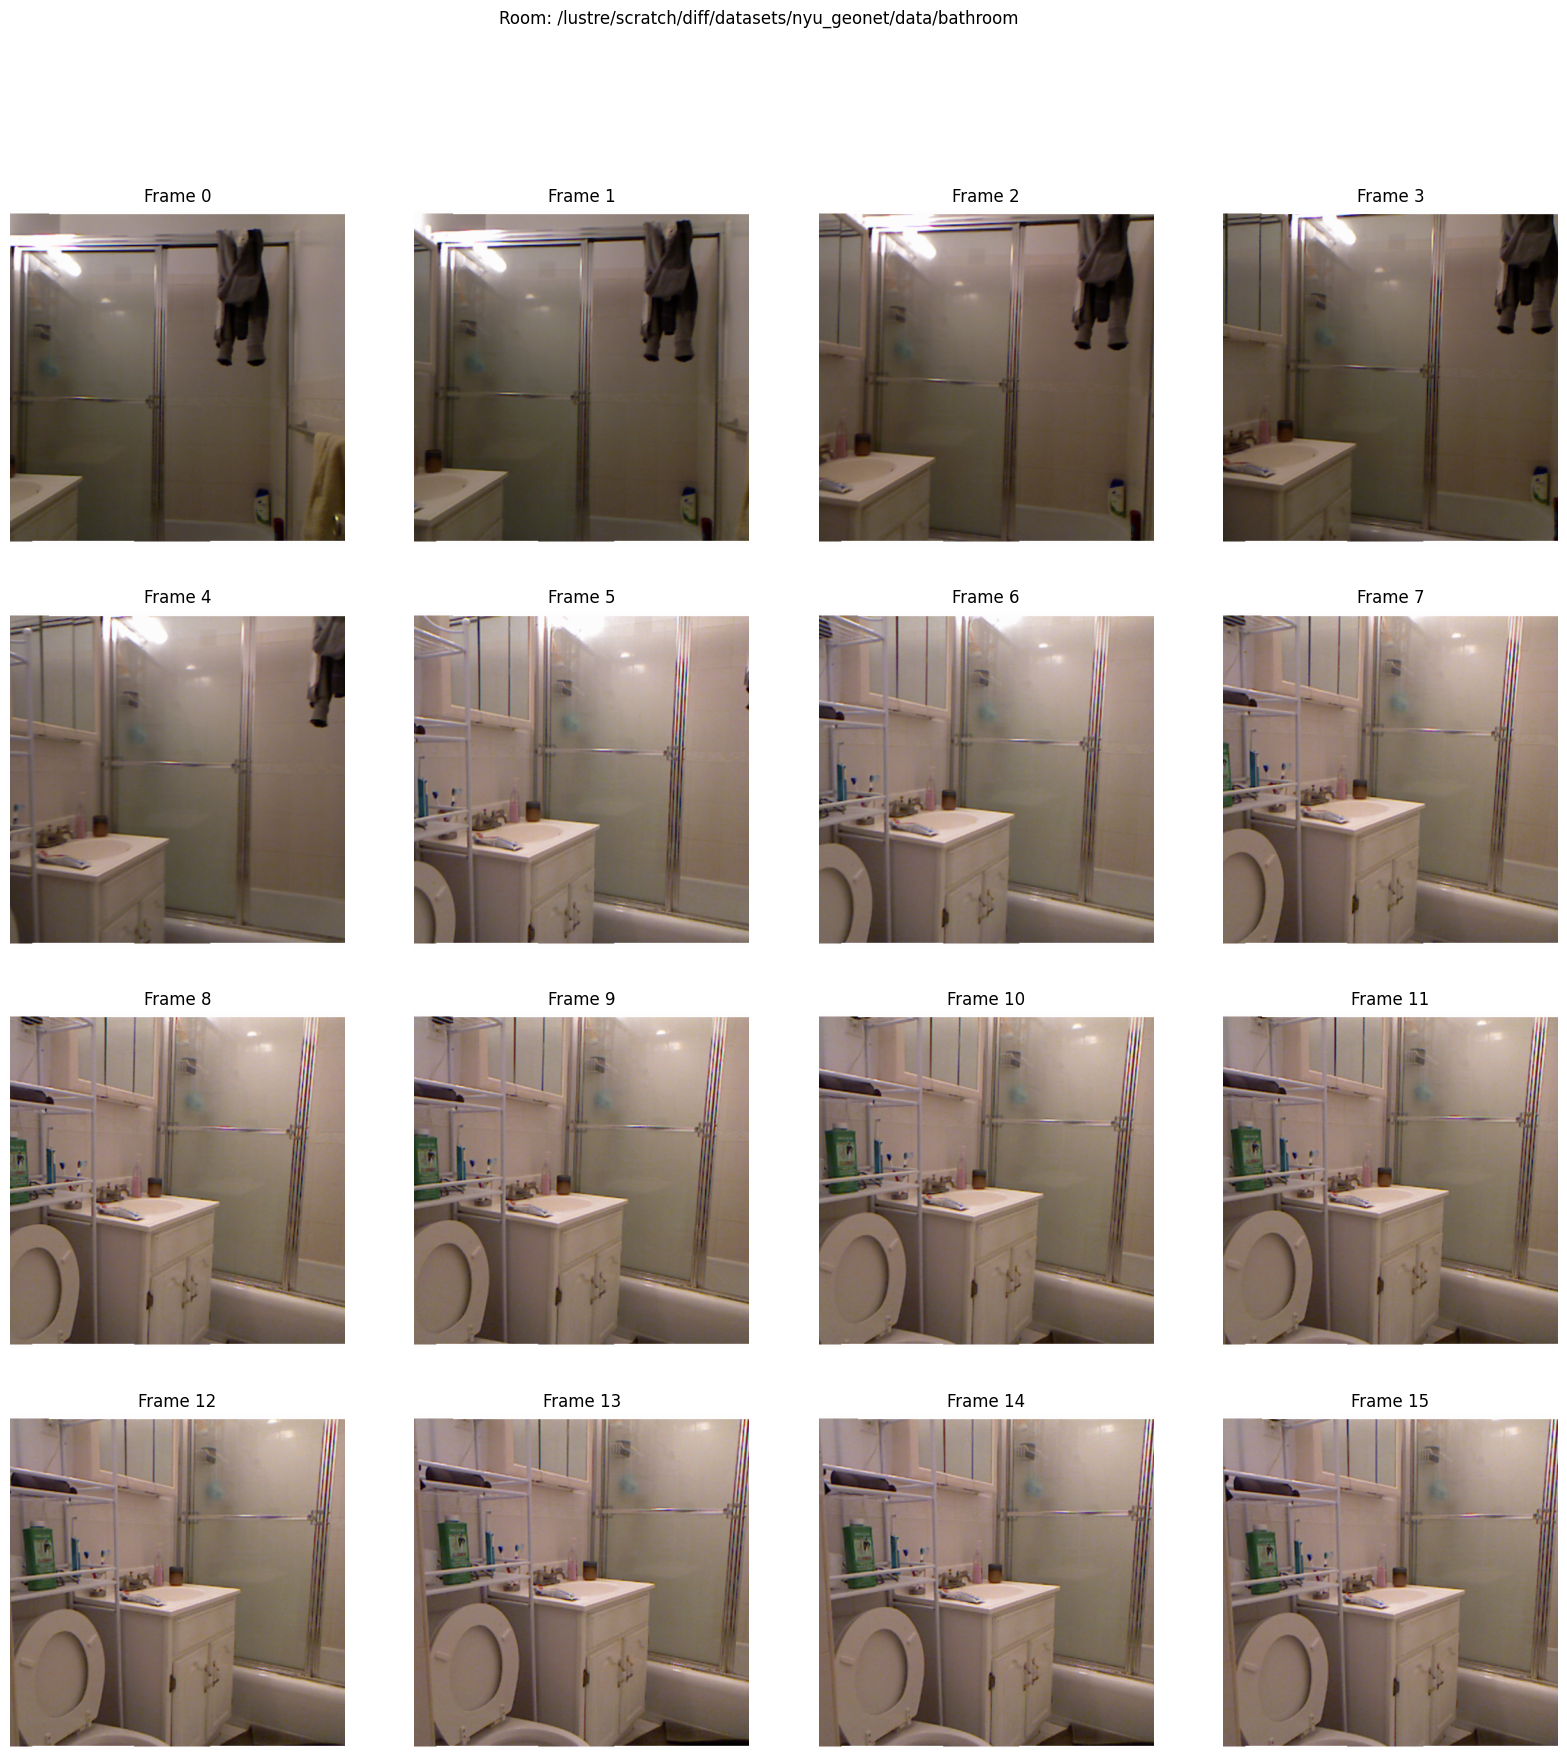

In [71]:
# plot the images
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, depth, snorm, room):
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))
    for i in range(16):
        axs[i // 4, i % 4].imshow(images[i].permute(1, 2, 0).numpy())
        axs[i // 4, i % 4].set_title(f"Frame {i}")
        axs[i // 4, i % 4].axis("off")
    plt.suptitle(f"Room: {room}")
    plt.show()


plot_images(x["image"], x["depth"], x["snorm"], x["room"])

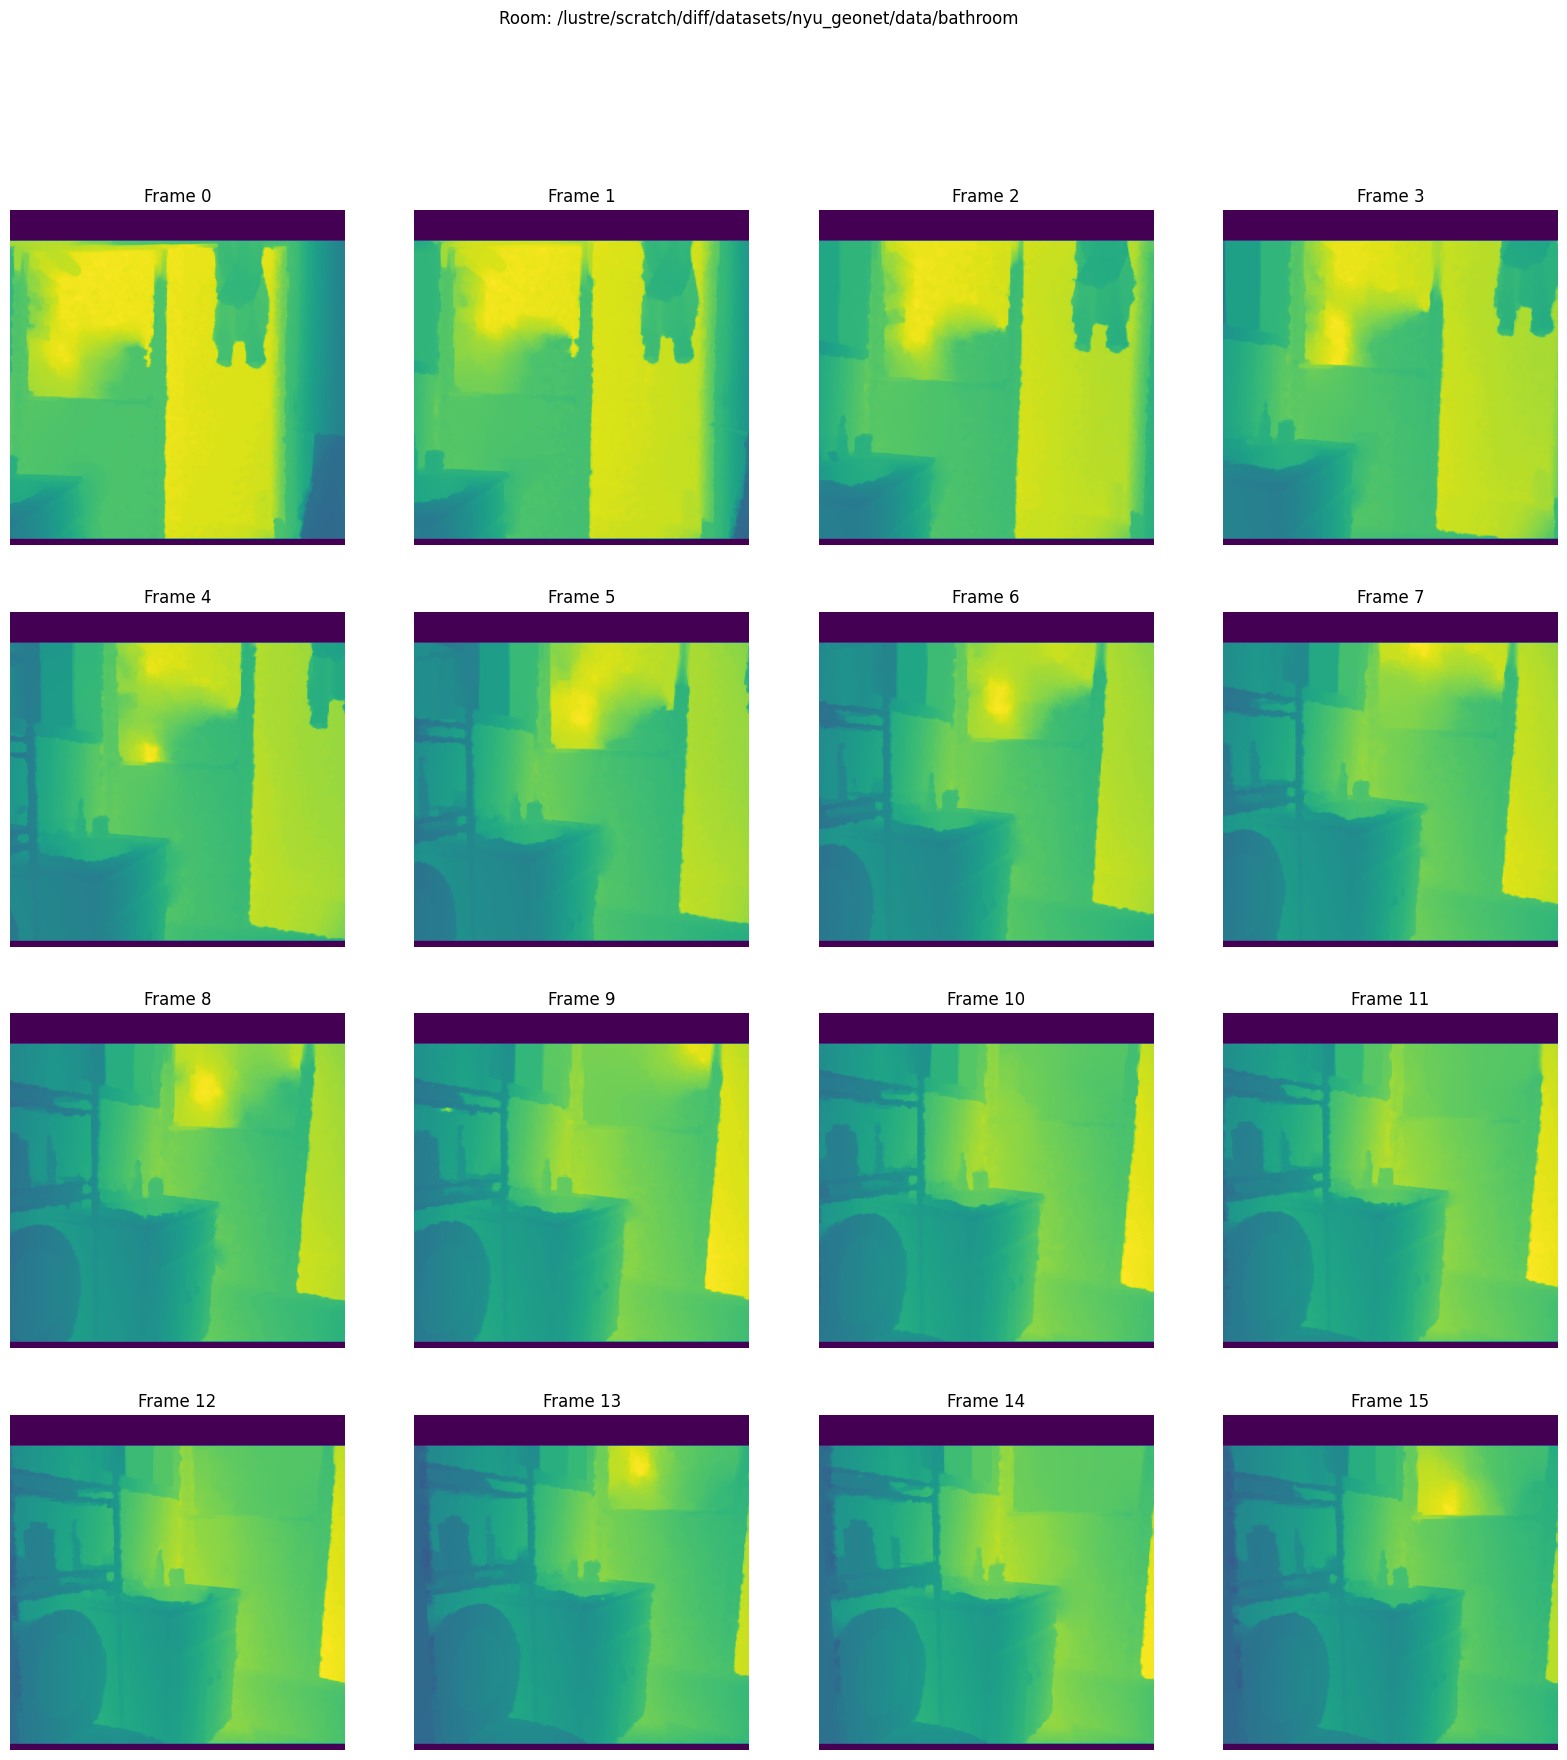

In [81]:
# plot depths 
def plot_depths(depths, room):
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))
    for i in range(16):
        axs[i // 4, i % 4].imshow(depths[i][0].numpy())
        axs[i // 4, i % 4].set_title(f"Frame {i}")
        axs[i // 4, i % 4].axis("off")
    plt.suptitle(f"Room: {room}")
    plt.show()


plot_depths(x["depth"], x["room"])

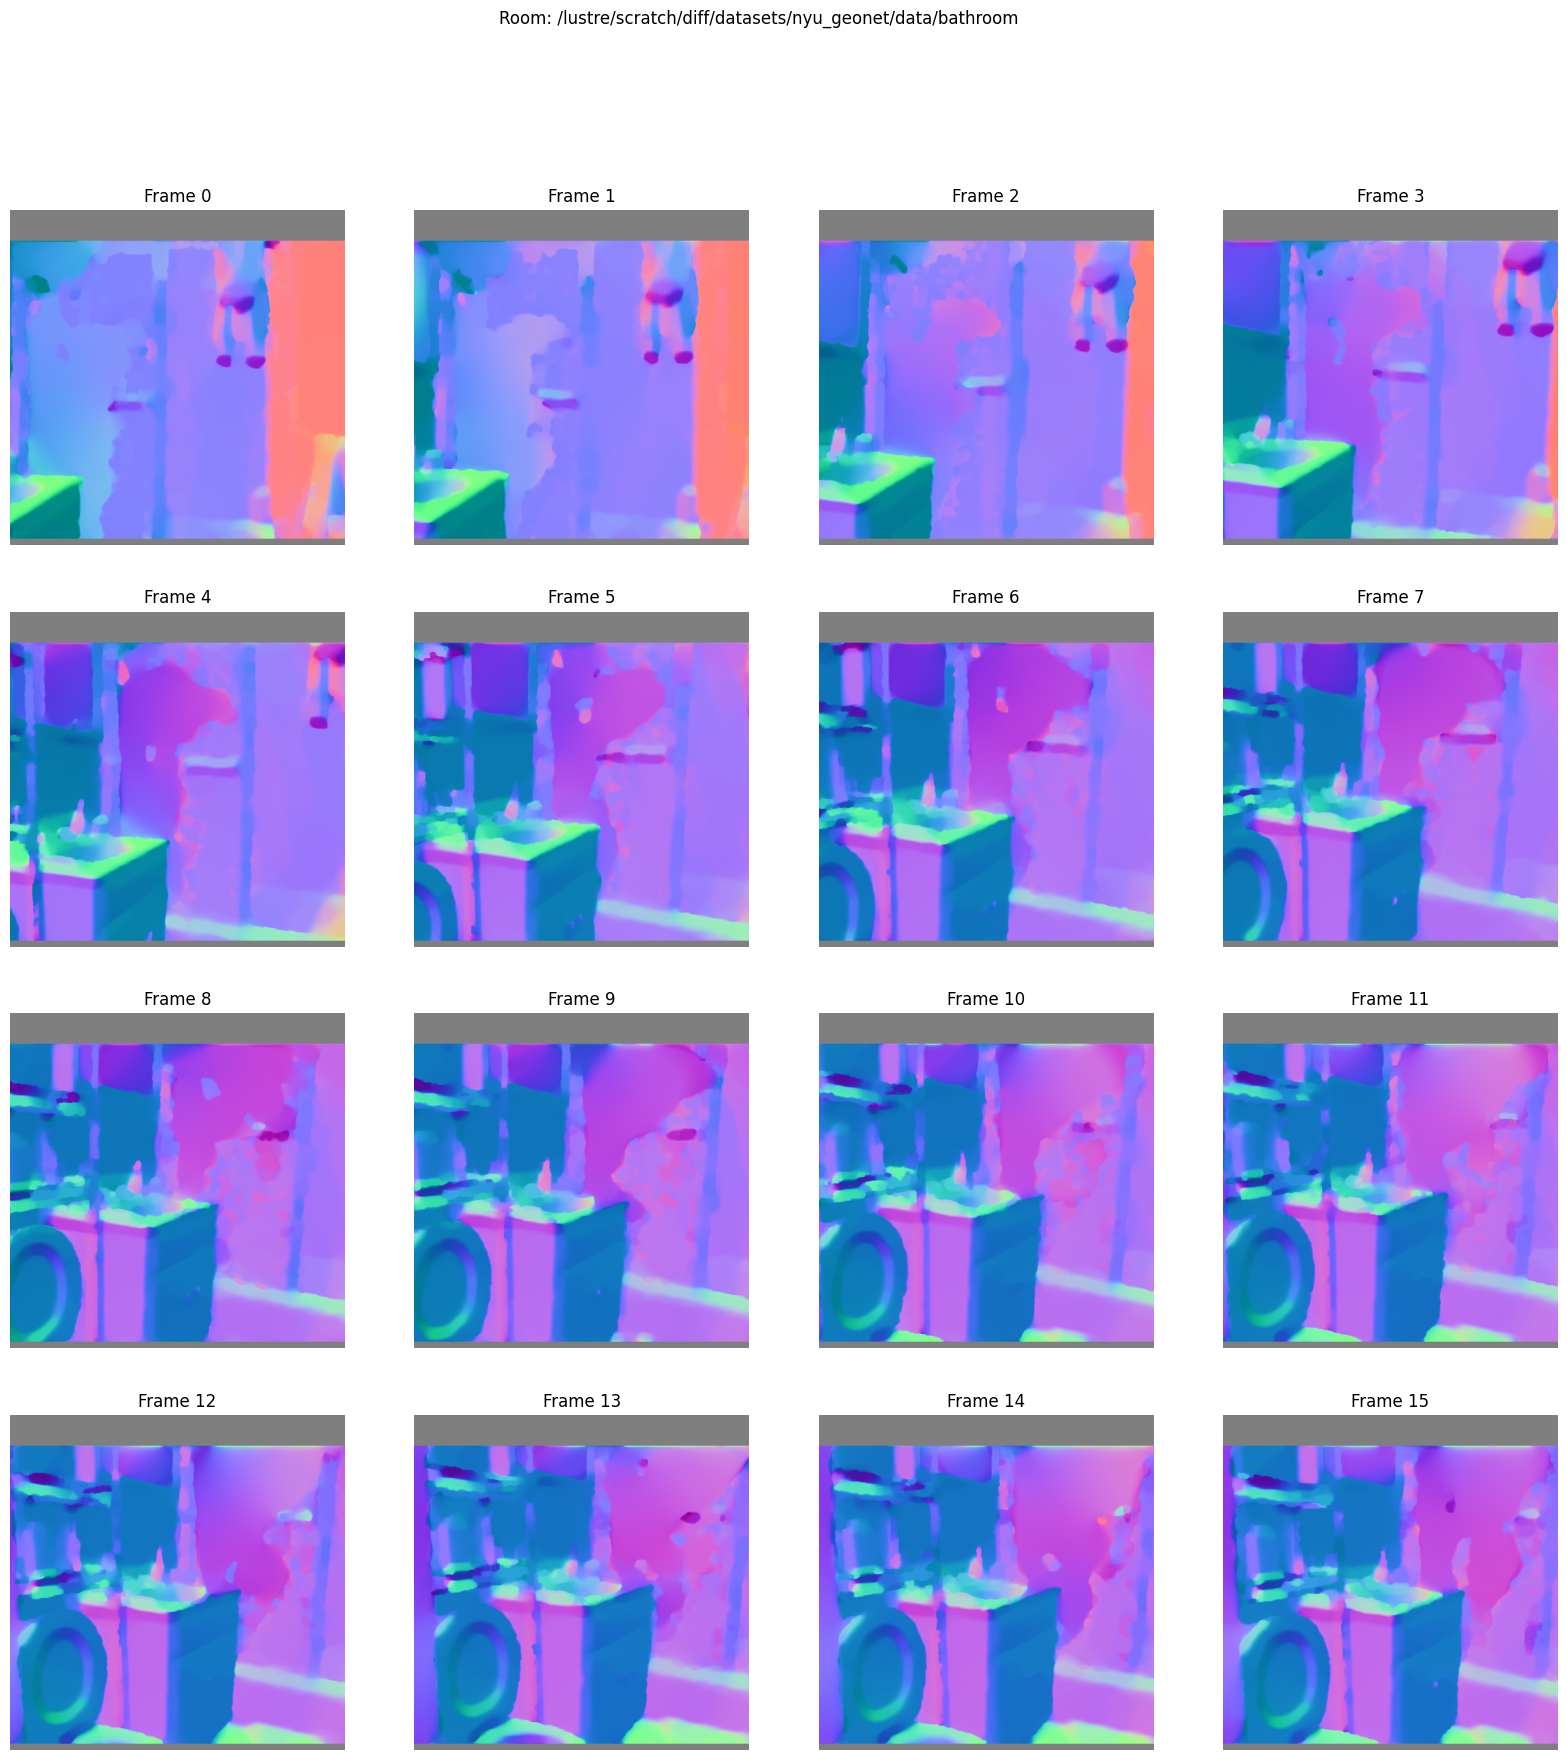

In [102]:
# visualize the surface normals
def plot_snorms(snorms, room):
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))
    for i in range(16):
        snorm = snorms[i].permute(1, 2, 0).numpy()
        snorm = (snorm + 1) / 2
        axs[i // 4, i % 4].imshow(snorm)
        axs[i // 4, i % 4].set_title(f"Frame {i}")
        axs[i // 4, i % 4].axis("off")
    plt.suptitle(f"Room: {room}")
    plt.show()
 

plot_snorms(x["snorm"], x["room"])

In [54]:
# create dataloader 
from torch.utils.data import DataLoader
dataloader = DataLoader(data_video, batch_size=8, shuffle=True) 


In [57]:
# test dataloader
for i, data in enumerate(dataloader):
    print(len(data))
    # print(i, data["image"].shape, data["depth"].shape, data["snorm"].shape)
    break

16


In [61]:
# test dataloader
for i, data in enumerate(dataloader):
    print(len(data))
    # print(i, data["image"].shape, data["depth"].shape, data["snorm"].shape)
    break

16


## Load data NYUv2 test set

In [ ]:
class NYU_test_old(torch.utils.data.Dataset):
    """
    Dataset loader based on Ishan Misra's SSL benchmark
    """

    def __init__(self, path, image_mean="imagenet", center_crop=False):
        super().__init__()
        self.name = "NYUv2"
        self.center_crop = center_crop
        self.max_depth = 10.0

        # get transforms
        image_size = (480, 480) if center_crop else (480, 640)
        self.image_transform, self.shared_transform = get_nyu_transforms(
            image_mean,
            image_size,
            False,
            rotateflip=False,
            additional_targets={"depth": "image", "snorm": "image"},
        )

        # parse data
        with open(path, "rb") as f:
            data_dict = pickle.load(f)

        self.indices = data_dict["test_indices"]
        self.depths = [data_dict["depths"][_i] for _i in self.indices]
        self.images = [data_dict["images"][_i] for _i in self.indices]
        self.scenes = [data_dict["scene_types"][_i][0] for _i in self.indices]
        self.snorms = [data_dict["snorms"][_i] for _i in self.indices]

        num_instances = len(self.indices)
        print(f"NYUv2 labeled test set: {num_instances} instances")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        image = self.images[index]
        depth = self.depths[index]
        snorm = self.snorms[index]
        room = self.scenes[index]
        nyu_index = self.indices[index]

        # transform image
        image = np.transpose(image, (1, 2, 0))
        image = self.image_transform(image)

        # set max depth to 10
        depth[depth > 10] = 0

        # center crop
        if self.center_crop:
            image = image[..., 80:-80]
            depth = depth[..., 80:-80]
            snorm = snorm[..., 80:-80]

        # move to tensor
        depth = torch.tensor(depth).float()[None, :, :]
        snorm = torch.tensor(snorm).float()

        return {
            "image": image,
            "depth": depth,
            "snorm": snorm,
            "room": room,
            "nyu_index": nyu_index,
        }

In [104]:
import mat73

In [105]:
nyuv2_dict = mat73.loadmat("/lustre/scratch/diff/datasets/nyuv2/nyu_depth_v2_labeled.mat")

ERROR:root:ERROR: MATLAB type not supported: containers.Map, (uint32)


In [106]:
nyuv2_dict.keys()

dict_keys(['accelData', 'depths', 'images', 'instances', 'labels', 'names', 'namesToIds', 'rawDepthFilenames', 'rawDepths', 'rawRgbFilenames', 'sceneTypes', 'scenes'])

In [119]:
sorted(nyuv2_dict["rawRgbFilenames"])

[['basement_0001a/r-1316653580.774394-1334503209.ppm'],
 ['basement_0001a/r-1316653591.579597-1982596359.ppm'],
 ['basement_0001a/r-1316653613.813694-3316788121.ppm'],
 ['basement_0001a/r-1316653624.884491-3980883571.ppm'],
 ['basement_0001a/r-1316653629.089885-4232919796.ppm'],
 ['basement_0001b/r-1316653649.248179-1148126438.ppm'],
 ['basement_0001b/r-1316653659.548292-1766215275.ppm'],
 ['bathroom_0001/r-1294886889.051208-365592038.ppm'],
 ['bathroom_0002/r-1295148733.248304-3836198014.ppm'],
 ['bathroom_0002/r-1295148736.261033-4016223889.ppm'],
 ['bathroom_0003/r-1295406974.176729-3401446534.ppm'],
 ['bathroom_0004/r-1295836681.712073-1755069346.ppm'],
 ['bathroom_0005/r-1295837594.698575-3478376057.ppm'],
 ['bathroom_0006/r-1295839279.324567-1475688615.ppm'],
 ['bathroom_0007/r-1299814498.965823-2514652658.ppm'],
 ['bathroom_0007/r-1299814511.509091-3266760758.ppm'],
 ['bathroom_0008/r-1300200406.257365-3105838053.ppm'],
 ['bathroom_0009/r-1300302685.118673-2801807861.ppm'],
 ['b

In [140]:
len([x for x in sorted(nyuv2_dict["rawRgbFilenames"]) if "kitchen_0010" in x[0]])

4

In [116]:
nyuv2_dict["depths"].shape

(480, 640, 1449)